üì• Chargement des donn√©es...
‚úì Donn√©es pr√™tes : torch.Size([90, 1, 64, 641]) √©chantillons
üß† Mod√®le EEGNetLight initialis√© ‚Äî 64 canaux, 641 temps, 3 classes
üß† Epoch 01 ‚Äî Loss: 24.6736 ‚Äî Acc: 42.22%
üß† Epoch 02 ‚Äî Loss: 23.3244 ‚Äî Acc: 50.00%
üß† Epoch 03 ‚Äî Loss: 21.3809 ‚Äî Acc: 53.33%
üß† Epoch 04 ‚Äî Loss: 17.7818 ‚Äî Acc: 67.78%
üß† Epoch 05 ‚Äî Loss: 15.0534 ‚Äî Acc: 80.00%
üß† Epoch 06 ‚Äî Loss: 13.0926 ‚Äî Acc: 85.56%
üß† Epoch 07 ‚Äî Loss: 10.6797 ‚Äî Acc: 86.67%
üß† Epoch 08 ‚Äî Loss: 8.3771 ‚Äî Acc: 90.00%
üß† Epoch 09 ‚Äî Loss: 5.8140 ‚Äî Acc: 94.44%
üß† Epoch 10 ‚Äî Loss: 4.0713 ‚Äî Acc: 97.78%

‚úÖ Mod√®le Enregistr√© : ../../models/eegnet_subject1_simple.pth


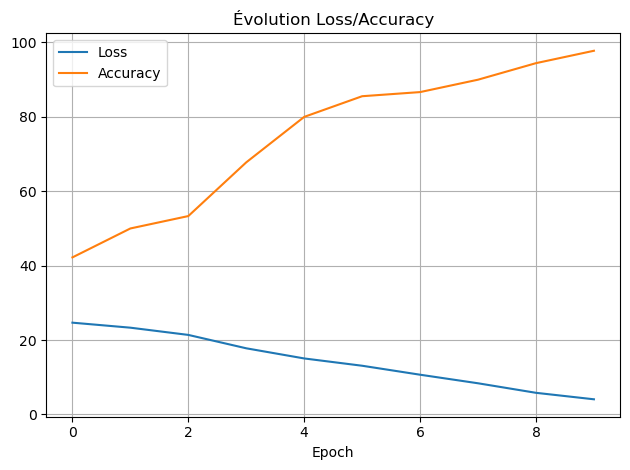

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os, sys
import matplotlib.pyplot as plt

# Patch anti-crash Intel/OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Ajouter le dossier racine au path pour acc√©der √† src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

# Charger les donn√©es EEG (fichier unique)
print("üì• Chargement des donn√©es...")
data = np.load("../../data/processed/subject_1_epochs.npz")
X = data["X"]
y = data["y"]

# Pr√©paration des tenseurs
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # [N, 1, C, T]
y_tensor = torch.tensor(y - y.min(), dtype=torch.long)        # correction des labels
print(f"‚úì Donn√©es pr√™tes : {X_tensor.shape} √©chantillons")

# Dataset & DataLoader
ds = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(ds, batch_size=4, shuffle=True)  # üîß batch size r√©duit

# Initialiser le mod√®le
n_channels, n_timepoints = X.shape[1], X.shape[2]
n_classes = len(torch.unique(y_tensor))
model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
print(f"üß† Mod√®le EEGNetLight initialis√© ‚Äî {n_channels} canaux, {n_timepoints} temps, {n_classes} classes")

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entra√Ænement
losses = []
accuracies = []
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)

    acc = 100 * correct / total
    losses.append(total_loss)
    accuracies.append(acc)
    print(f"üß† Epoch {epoch+1:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc:.2f}%")

# Sauvegarde du mod√®le
os.makedirs("../../models", exist_ok=True)
torch.save(model.state_dict(), "../../models/eegnet_subject1_simple.pth")
print("\n‚úÖ Mod√®le Enregistr√© : ../../models/eegnet_subject1_simple.pth")

# Courbe de suivi
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.title("√âvolution Loss/Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


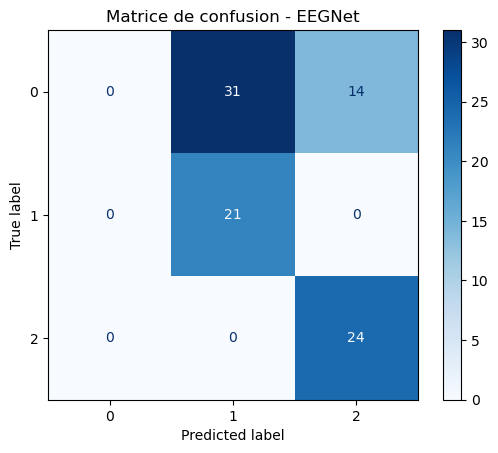

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pr√©dictions globales
model.eval()
with torch.no_grad():
    all_preds = model(X_tensor).argmax(1)

# Matrice de confusion
cm = confusion_matrix(y_tensor, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - EEGNet")
plt.show()


In [3]:
np.savez("../../models/eegnet_subject1_simple_stats.npz",
         losses=np.array(losses),
         accuracies=np.array(accuracies))
print("üìä Courbes enregistr√©es dans eegnet_subject1_simple_stats.npz")


üìä Courbes enregistr√©es dans eegnet_subject1_simple_stats.npz


In [4]:
idx = 3
example = X_tensor[idx:idx+1]

model.eval()
with torch.no_grad():
    proba = torch.softmax(model(example), dim=1)

print(f"Vraie √©tiquette : {y_tensor[idx].item()} ‚Äî Pr√©dictions : {proba.numpy().round(3)}")


Vraie √©tiquette : 1 ‚Äî Pr√©dictions : [[0.    0.992 0.008]]


In [5]:
unique, counts = torch.unique(y_tensor, return_counts=True)
for cls, count in zip(unique.tolist(), counts.tolist()):
    print(f"Classe {cls} : {count} √©chantillons")


Classe 0 : 45 √©chantillons
Classe 1 : 21 √©chantillons
Classe 2 : 24 √©chantillons


In [6]:
from src.preprocessing.windowing import extract_epochs_from_annotations
import mne, os

subject = 1
runs = [6, 10, 14]
output_dir = "../../data/processed"
os.makedirs(output_dir, exist_ok=True)

for run in runs:
    files = mne.datasets.eegbci.load_data(subjects=[subject], runs=[run])
    raw = mne.io.read_raw_edf(files[0], preload=True)

    raw.rename_channels(lambda name: name.strip(".").upper())
    raw.set_montage("standard_1020", on_missing="ignore")

    X, y = extract_epochs_from_annotations(
        raw, tmin=0.0, tmax=4.0,
        output_path=os.path.join(output_dir, f"subject_{subject}_run_{run}_epochs.npz")
    )
    print(f"‚úÖ Run {run} export√© : {X.shape} √©chantillons")


Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
‚úÖ Extraction des √©v√©nements depuis les annotations...
‚úÖ 30 √©v√©nements d√©tect√©s : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
üìÄ Sauvegarde effectu√©e dans : ../../data/processed\subject_1_run_6_epochs.npz
üî¢ Extraction des donn√©es numpy : (30, 64, 641) ‚Äî Labels : [0 1 2]
‚úÖ Run 6 export√© : (30, 64, 641) √©chantillons
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
‚úÖ Extraction des √©v√©nements depuis les annotations...
‚úÖ 30 √©v√©nements d√©tect√©s : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
üì

üß† Epoch 01 ‚Äî Loss: 9.8711 ‚Äî Acc: 41.67%
üß† Epoch 02 ‚Äî Loss: 9.4839 ‚Äî Acc: 52.78%
üß† Epoch 03 ‚Äî Loss: 8.8912 ‚Äî Acc: 52.78%
üß† Epoch 04 ‚Äî Loss: 8.3388 ‚Äî Acc: 54.17%
üß† Epoch 05 ‚Äî Loss: 7.1497 ‚Äî Acc: 61.11%
üß† Epoch 06 ‚Äî Loss: 5.8098 ‚Äî Acc: 73.61%
üß† Epoch 07 ‚Äî Loss: 4.4884 ‚Äî Acc: 81.94%
üß† Epoch 08 ‚Äî Loss: 3.6548 ‚Äî Acc: 84.72%
üß† Epoch 09 ‚Äî Loss: 2.8067 ‚Äî Acc: 93.06%
üß† Epoch 10 ‚Äî Loss: 2.2302 ‚Äî Acc: 95.83%

‚úÖ Mod√®le multirun sauvegard√© dans : ../../models/eegnet_subject1_multirun.pth



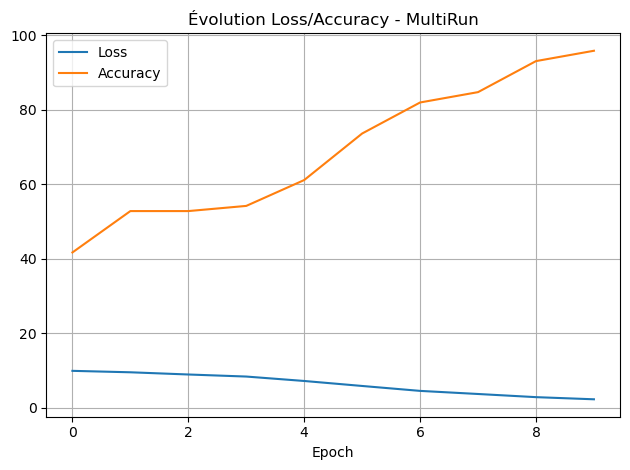

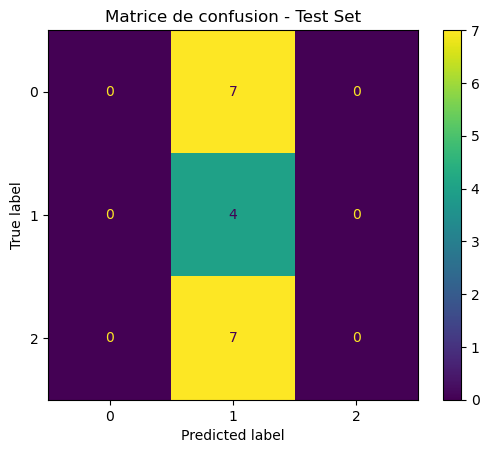


üîç Exemple ‚Äî Pr√©diction : [[0.    0.953 0.047]]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, random_split
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ajouter le dossier racine au path pour acc√©der √† src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concat√©ner les donn√©es de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()  # Corriger les labels si besoin
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    # Concat√©ner tous les jeux de donn√©es
    full_ds = ConcatDataset(datasets)

    # Split entra√Ænement/test (80/20)
    train_size = int(0.8 * len(full_ds))
    test_size = len(full_ds) - train_size
    train_ds, test_ds = random_split(full_ds, [train_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=8)

    # Initialiser le mod√®le
    n_channels, n_timepoints = X.shape[1], X.shape[2]
    all_labels = torch.cat([d.tensors[1] for d in datasets])
    n_classes = len(torch.unique(all_labels))
    model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    losses, accuracies = [], []

    # Entra√Ænement
    for epoch in range(10):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)

        acc = 100 * correct / total
        losses.append(total_loss)
        accuracies.append(acc)
        print(f"üß† Epoch {epoch+1:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc:.2f}%")

    # Sauvegarde
    model_path = "../../models/eegnet_subject1_multirun.pth"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"\n‚úÖ Mod√®le multirun sauvegard√© dans : {model_path}\n")

    # Courbes
    plt.plot(losses, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.title("√âvolution Loss/Accuracy - MultiRun")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # √âvaluation finale sur test set
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_true.extend(yb.numpy())
            y_pred.extend(preds.argmax(1).numpy())

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title("Matrice de confusion - Test Set")
    plt.grid(False)
    plt.show()

    # Exemple pr√©diction unique
    example = test_ds[0][0].unsqueeze(0)  # Ajouter batch dim
    with torch.no_grad():
        proba = torch.softmax(model(example), dim=1)
    print(f"\nüîç Exemple ‚Äî Pr√©diction : {proba.numpy().round(3)}")

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 9.8314 ‚Äî Acc: 48.61%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 9.3956 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 9.0492 ‚Äî Acc: 50.00%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 8.3387 ‚Äî Acc: 51.39%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 7.3559 ‚Äî Acc: 69.44%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 6.2354 ‚Äî Acc: 80.56%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 4.8825 ‚Äî Acc: 83.33%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 3.8275 ‚Äî Acc: 88.89%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 2.9647 ‚Äî Acc: 90.28%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 2.4280 ‚Äî Acc: 91.67%


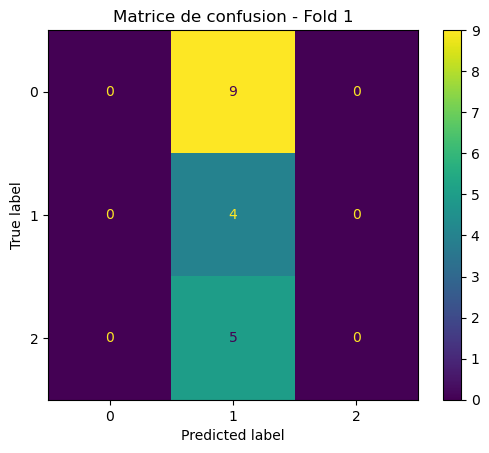

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 9.8546 ‚Äî Acc: 37.50%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 9.3866 ‚Äî Acc: 51.39%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 8.6476 ‚Äî Acc: 50.00%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 7.6895 ‚Äî Acc: 52.78%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 6.3300 ‚Äî Acc: 79.17%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 4.9689 ‚Äî Acc: 83.33%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 3.9828 ‚Äî Acc: 87.50%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 3.0855 ‚Äî Acc: 91.67%
üß† Fold 2 ‚Äî Epoch 09 ‚Äî Loss: 2.3911 ‚Äî Acc: 93.06%
üß† Fold 2 ‚Äî Epoch 10 ‚Äî Loss: 1.8105 ‚Äî Acc: 97.22%


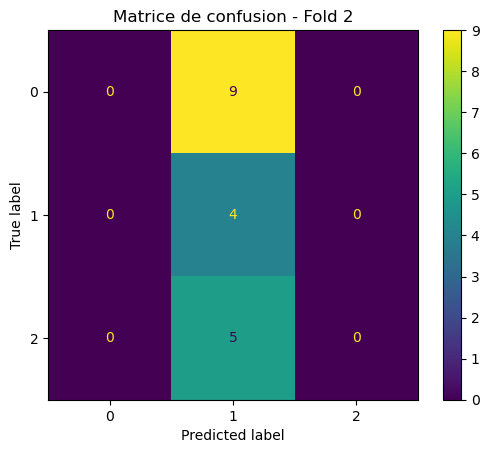

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 9.8288 ‚Äî Acc: 52.78%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 9.4156 ‚Äî Acc: 51.39%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 8.7725 ‚Äî Acc: 50.00%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 8.0093 ‚Äî Acc: 56.94%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 6.6938 ‚Äî Acc: 73.61%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 5.5203 ‚Äî Acc: 81.94%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 4.7853 ‚Äî Acc: 84.72%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 3.8980 ‚Äî Acc: 88.89%
üß† Fold 3 ‚Äî Epoch 09 ‚Äî Loss: 3.3332 ‚Äî Acc: 90.28%
üß† Fold 3 ‚Äî Epoch 10 ‚Äî Loss: 2.6908 ‚Äî Acc: 91.67%


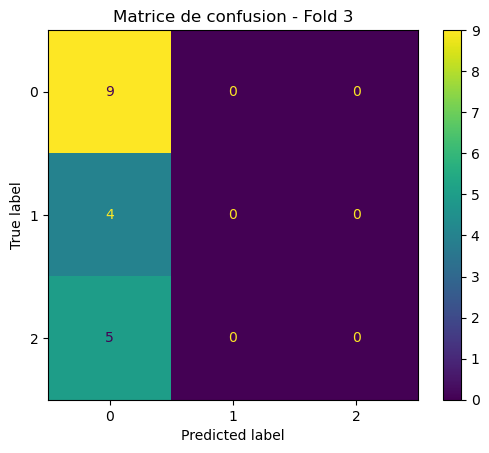

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 9.8357 ‚Äî Acc: 47.22%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 9.4840 ‚Äî Acc: 50.00%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 8.7954 ‚Äî Acc: 50.00%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 7.8958 ‚Äî Acc: 51.39%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 6.4438 ‚Äî Acc: 76.39%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 5.3118 ‚Äî Acc: 83.33%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 4.3339 ‚Äî Acc: 84.72%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 3.6629 ‚Äî Acc: 87.50%
üß† Fold 4 ‚Äî Epoch 09 ‚Äî Loss: 3.0003 ‚Äî Acc: 93.06%
üß† Fold 4 ‚Äî Epoch 10 ‚Äî Loss: 2.0391 ‚Äî Acc: 95.83%


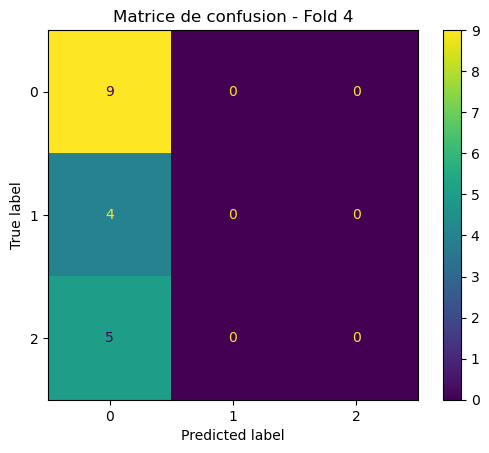

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 9.8503 ‚Äî Acc: 36.11%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 9.4510 ‚Äî Acc: 50.00%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 8.8277 ‚Äî Acc: 50.00%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 8.0275 ‚Äî Acc: 54.17%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 6.9460 ‚Äî Acc: 62.50%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 5.6228 ‚Äî Acc: 79.17%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 4.7882 ‚Äî Acc: 80.56%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 3.7393 ‚Äî Acc: 84.72%
üß† Fold 5 ‚Äî Epoch 09 ‚Äî Loss: 2.9914 ‚Äî Acc: 90.28%
üß† Fold 5 ‚Äî Epoch 10 ‚Äî Loss: 2.3236 ‚Äî Acc: 91.67%


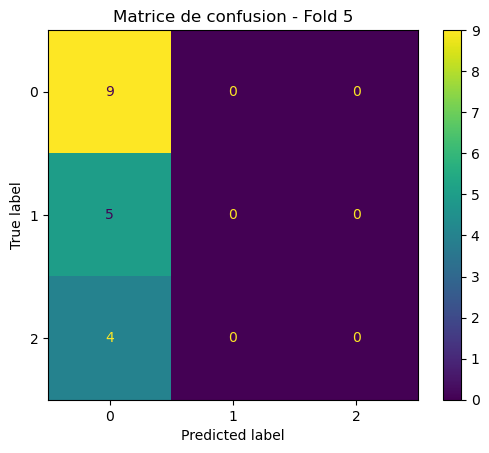

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold5_stats.npz

===== R√©sum√© global sur 5 folds =====
üìä Moyenne des Loss : 2.2584 ¬± 0.3061
üìà Moyenne des Accuracy : 93.61% ¬± 2.42%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour acc√©der √† src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concat√©ner les donn√©es de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    # 1. Validation crois√©e stratifi√©e (5 folds)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    all_losses = []
    all_accuracies = []

    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        X_train, y_train = full_X[train_idx], full_y[train_idx]
        X_test, y_test = full_X[test_idx], full_y[test_idx]

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

        # 2. Initialiser EEGNet
        n_channels, n_timepoints = X.shape[1], X.shape[2]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"üß† Fold {fold} ‚Äî Epoch {epoch+1:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc:.2f}%")

        # 3. Analyse des erreurs
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        # 4. Exporter les stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"üì¶ Courbes sauvegard√©es dans eegnet_subject{subject}_fold{fold}_stats.npz")

        all_losses.append(losses[-1])
        all_accuracies.append(accuracies[-1])
        fold += 1

    # 5. R√©sum√© global
    print("\n===== R√©sum√© global sur 5 folds =====")
    print(f"üìä Moyenne des Loss : {np.mean(all_losses):.4f} ¬± {np.std(all_losses):.4f}")
    print(f"üìà Moyenne des Accuracy : {np.mean(all_accuracies):.2f}% ¬± {np.std(all_accuracies):.2f}%")

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
üî¢ R√©partition y_train : tensor([36, 17, 19])
üî¢ R√©partition y_test  : tensor([9, 4, 5])
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 9.7841 ‚Äî Acc: 36.11%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 9.5144 ‚Äî Acc: 41.67%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 8.7528 ‚Äî Acc: 56.94%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 7.6266 ‚Äî Acc: 51.39%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 6.3685 ‚Äî Acc: 55.56%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 7.0283 ‚Äî Acc: 56.94%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 5.7200 ‚Äî Acc: 73.61%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 5.3507 ‚Äî Acc: 75.00%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 3.6575 ‚Äî Acc: 84.72%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 3.4578 ‚Äî Acc: 86.11%


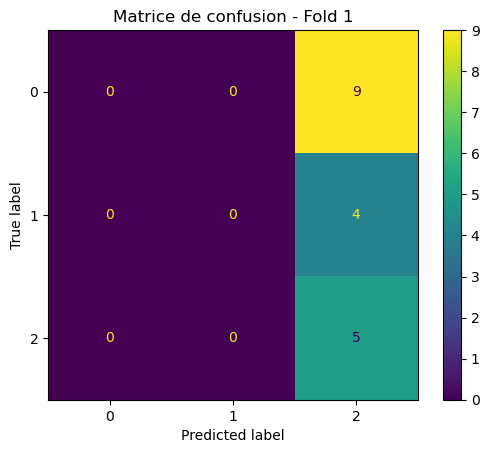


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         4
           2       0.28      1.00      0.43         5

    accuracy                           0.28        18
   macro avg       0.09      0.33      0.14        18
weighted avg       0.08      0.28      0.12        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
üî¢ R√©partition y_train : tensor([36, 17, 19])
üî¢ R√©partition y_test  : tensor([9, 4, 5])
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 9.8118 ‚Äî Acc: 37.50%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 9.5135 ‚Äî Acc: 51.39%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 8.5370 ‚Äî Acc: 65.28%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 7.7343 ‚Äî Acc: 62.50%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 6.4057 ‚Äî Acc: 62.50%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 5.6490 ‚Äî Acc: 75.00%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 4.0173 ‚Äî Acc: 79.17%


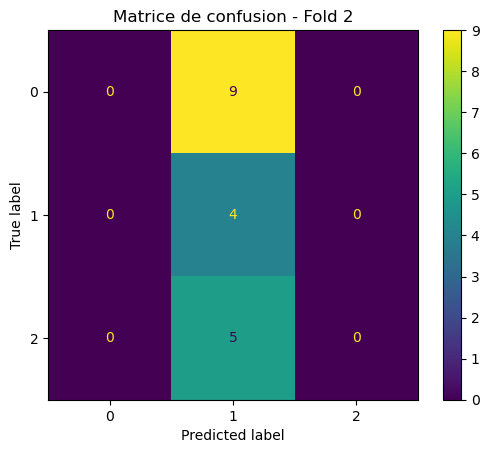


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.22      1.00      0.36         4
           2       0.00      0.00      0.00         5

    accuracy                           0.22        18
   macro avg       0.07      0.33      0.12        18
weighted avg       0.05      0.22      0.08        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
üî¢ R√©partition y_train : tensor([36, 17, 19])
üî¢ R√©partition y_test  : tensor([9, 4, 5])
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 9.8125 ‚Äî Acc: 40.28%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 9.4859 ‚Äî Acc: 36.11%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 8.4250 ‚Äî Acc: 47.22%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 8.6516 ‚Äî Acc: 36.11%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 6.1536 ‚Äî Acc: 69.44%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 5.6236 ‚Äî Acc: 73.61%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 5.2443 ‚Äî Acc: 70.83%


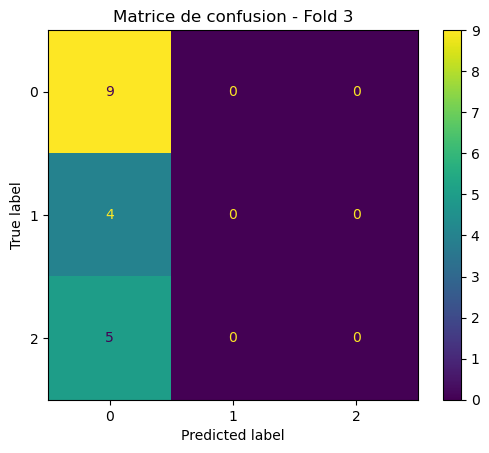


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
üî¢ R√©partition y_train : tensor([36, 17, 19])
üî¢ R√©partition y_test  : tensor([9, 4, 5])
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 9.7736 ‚Äî Acc: 48.61%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 8.9971 ‚Äî Acc: 63.89%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 7.7265 ‚Äî Acc: 58.33%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 8.5836 ‚Äî Acc: 41.67%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 7.7746 ‚Äî Acc: 54.17%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 6.0328 ‚Äî Acc: 73.61%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 4.9515 ‚Äî Acc: 81.94%


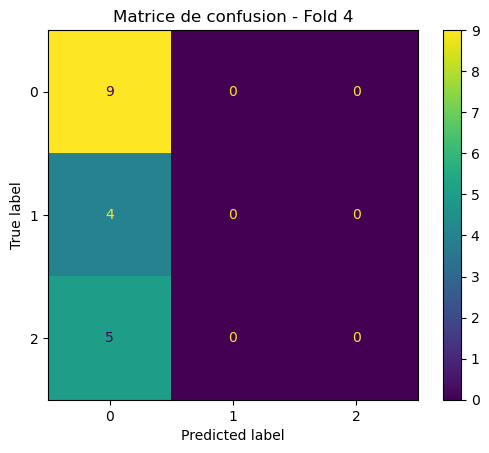


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
üî¢ R√©partition y_train : tensor([36, 16, 20])
üî¢ R√©partition y_test  : tensor([9, 5, 4])
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 9.8154 ‚Äî Acc: 44.44%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 9.4565 ‚Äî Acc: 38.89%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 9.5109 ‚Äî Acc: 23.61%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 8.4764 ‚Äî Acc: 58.33%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 7.2215 ‚Äî Acc: 77.78%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 6.0725 ‚Äî Acc: 73.61%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 3.8592 ‚Äî Acc: 87.50%


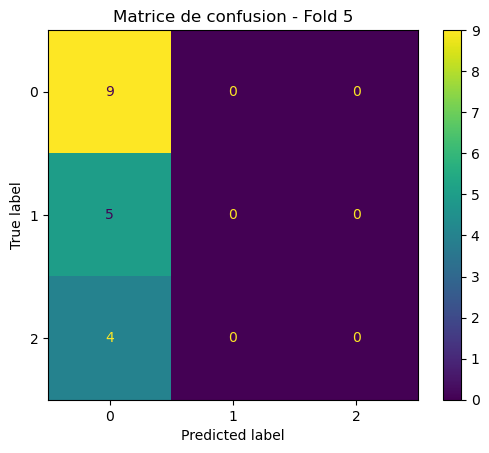


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         4

    accuracy                           0.50        18
   macro avg       0.17      0.33      0.22        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold5_stats.npz


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, WeightedRandomSampler
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour acc√©der √† src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concat√©ner les donn√©es de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"] - data["y"].min()
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    # 1. Validation crois√©e stratifi√©e (5 folds)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        X_train, y_train = full_X[train_idx], full_y[train_idx]
        X_test, y_test = full_X[test_idx], full_y[test_idx]

        print(f"üî¢ R√©partition y_train : {torch.bincount(y_train)}")
        print(f"üî¢ R√©partition y_test  : {torch.bincount(y_test)}")

        # √âchantillonnage √©quilibr√© via WeightedRandomSampler
        class_sample_count = torch.bincount(y_train)
        weights = 1. / class_sample_count.float()
        sample_weights = weights[y_train]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, sampler=sampler)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

        # 2. Initialiser EEGNet avec pond√©ration de classes
        n_channels, n_timepoints = X.shape[1], X.shape[2]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Calcul des poids de classes invers√©s
        class_weights = 1. / class_sample_count.float()
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"üß† Fold {fold} ‚Äî Epoch {epoch+1:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc:.2f}%")

        # 3. Analyse des erreurs
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        print("\nüîé Rapport de classification :")
        print(classification_report(y_true, y_pred, zero_division=0))

        # 4. Exporter les stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"üì¶ Courbes sauvegard√©es dans eegnet_subject{subject}_fold{fold}_stats.npz")

        fold += 1

if __name__ == "__main__":
    train_multirun()



===== Fold 1 =====
üî¢ R√©partition y_train : tensor([36, 36])
üî¢ R√©partition y_test  : tensor([9, 9])
üß† Fold 1 ‚Äî Epoch 01 ‚Äî Loss: 6.2181 ‚Äî Acc: 51.39%
üß† Fold 1 ‚Äî Epoch 02 ‚Äî Loss: 5.9626 ‚Äî Acc: 81.94%
üß† Fold 1 ‚Äî Epoch 03 ‚Äî Loss: 5.4687 ‚Äî Acc: 84.72%
üß† Fold 1 ‚Äî Epoch 04 ‚Äî Loss: 4.6722 ‚Äî Acc: 81.94%
üß† Fold 1 ‚Äî Epoch 05 ‚Äî Loss: 3.7323 ‚Äî Acc: 84.72%
üß† Fold 1 ‚Äî Epoch 06 ‚Äî Loss: 2.9871 ‚Äî Acc: 87.50%
üß† Fold 1 ‚Äî Epoch 07 ‚Äî Loss: 2.4144 ‚Äî Acc: 88.89%
üß† Fold 1 ‚Äî Epoch 08 ‚Äî Loss: 1.9750 ‚Äî Acc: 93.06%
üß† Fold 1 ‚Äî Epoch 09 ‚Äî Loss: 1.5844 ‚Äî Acc: 93.06%
üß† Fold 1 ‚Äî Epoch 10 ‚Äî Loss: 1.2285 ‚Äî Acc: 97.22%


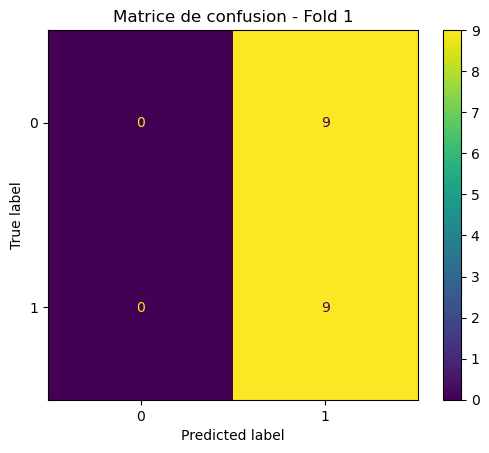


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold1_stats.npz

===== Fold 2 =====
üî¢ R√©partition y_train : tensor([36, 36])
üî¢ R√©partition y_test  : tensor([9, 9])
üß† Fold 2 ‚Äî Epoch 01 ‚Äî Loss: 6.2294 ‚Äî Acc: 55.56%
üß† Fold 2 ‚Äî Epoch 02 ‚Äî Loss: 6.1173 ‚Äî Acc: 80.56%
üß† Fold 2 ‚Äî Epoch 03 ‚Äî Loss: 5.7997 ‚Äî Acc: 79.17%
üß† Fold 2 ‚Äî Epoch 04 ‚Äî Loss: 5.1621 ‚Äî Acc: 84.72%
üß† Fold 2 ‚Äî Epoch 05 ‚Äî Loss: 4.4166 ‚Äî Acc: 81.94%
üß† Fold 2 ‚Äî Epoch 06 ‚Äî Loss: 3.4983 ‚Äî Acc: 83.33%
üß† Fold 2 ‚Äî Epoch 07 ‚Äî Loss: 3.0669 ‚Äî Acc: 88.89%
üß† Fold 2 ‚Äî Epoch 08 ‚Äî Loss: 2.5465 ‚Äî Acc: 93.06%
üß

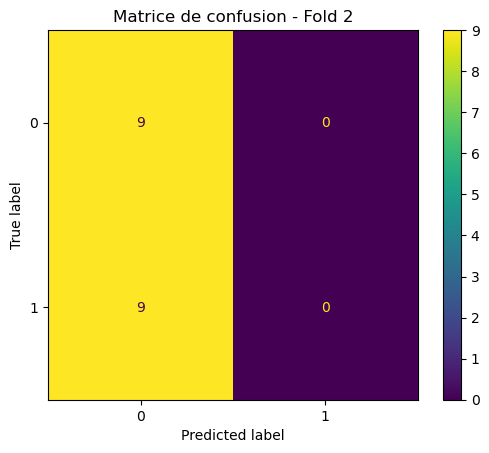


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold2_stats.npz

===== Fold 3 =====
üî¢ R√©partition y_train : tensor([36, 36])
üî¢ R√©partition y_test  : tensor([9, 9])
üß† Fold 3 ‚Äî Epoch 01 ‚Äî Loss: 6.2217 ‚Äî Acc: 52.78%
üß† Fold 3 ‚Äî Epoch 02 ‚Äî Loss: 6.0144 ‚Äî Acc: 86.11%
üß† Fold 3 ‚Äî Epoch 03 ‚Äî Loss: 5.5644 ‚Äî Acc: 84.72%
üß† Fold 3 ‚Äî Epoch 04 ‚Äî Loss: 4.8257 ‚Äî Acc: 86.11%
üß† Fold 3 ‚Äî Epoch 05 ‚Äî Loss: 3.7884 ‚Äî Acc: 86.11%
üß† Fold 3 ‚Äî Epoch 06 ‚Äî Loss: 3.0689 ‚Äî Acc: 88.89%
üß† Fold 3 ‚Äî Epoch 07 ‚Äî Loss: 2.6422 ‚Äî Acc: 88.89%
üß† Fold 3 ‚Äî Epoch 08 ‚Äî Loss: 2.1775 ‚Äî Acc: 94.44%
üß

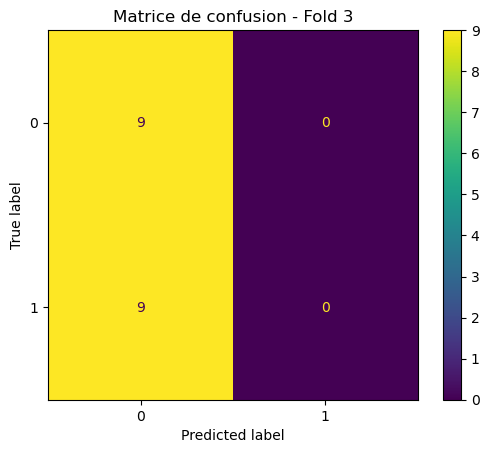


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold3_stats.npz

===== Fold 4 =====
üî¢ R√©partition y_train : tensor([36, 36])
üî¢ R√©partition y_test  : tensor([9, 9])
üß† Fold 4 ‚Äî Epoch 01 ‚Äî Loss: 6.2115 ‚Äî Acc: 58.33%
üß† Fold 4 ‚Äî Epoch 02 ‚Äî Loss: 5.9279 ‚Äî Acc: 81.94%
üß† Fold 4 ‚Äî Epoch 03 ‚Äî Loss: 5.3553 ‚Äî Acc: 83.33%
üß† Fold 4 ‚Äî Epoch 04 ‚Äî Loss: 4.5295 ‚Äî Acc: 81.94%
üß† Fold 4 ‚Äî Epoch 05 ‚Äî Loss: 3.4917 ‚Äî Acc: 81.94%
üß† Fold 4 ‚Äî Epoch 06 ‚Äî Loss: 2.9153 ‚Äî Acc: 87.50%
üß† Fold 4 ‚Äî Epoch 07 ‚Äî Loss: 2.4003 ‚Äî Acc: 93.06%
üß† Fold 4 ‚Äî Epoch 08 ‚Äî Loss: 1.9861 ‚Äî Acc: 94.44%
üß

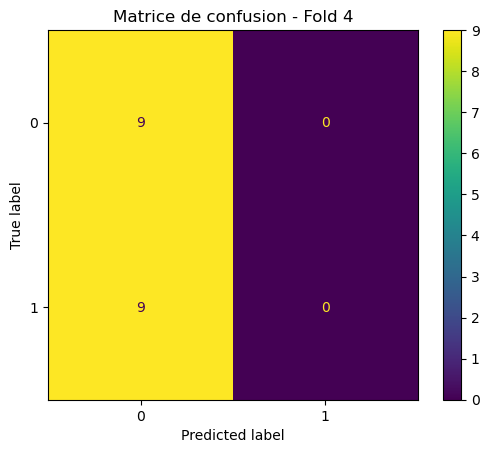


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold4_stats.npz

===== Fold 5 =====
üî¢ R√©partition y_train : tensor([36, 36])
üî¢ R√©partition y_test  : tensor([9, 9])
üß† Fold 5 ‚Äî Epoch 01 ‚Äî Loss: 6.1993 ‚Äî Acc: 63.89%
üß† Fold 5 ‚Äî Epoch 02 ‚Äî Loss: 5.9322 ‚Äî Acc: 86.11%
üß† Fold 5 ‚Äî Epoch 03 ‚Äî Loss: 5.3552 ‚Äî Acc: 84.72%
üß† Fold 5 ‚Äî Epoch 04 ‚Äî Loss: 4.4293 ‚Äî Acc: 86.11%
üß† Fold 5 ‚Äî Epoch 05 ‚Äî Loss: 3.5312 ‚Äî Acc: 86.11%
üß† Fold 5 ‚Äî Epoch 06 ‚Äî Loss: 3.2143 ‚Äî Acc: 86.11%
üß† Fold 5 ‚Äî Epoch 07 ‚Äî Loss: 2.9212 ‚Äî Acc: 88.89%
üß† Fold 5 ‚Äî Epoch 08 ‚Äî Loss: 2.5513 ‚Äî Acc: 90.28%
üß

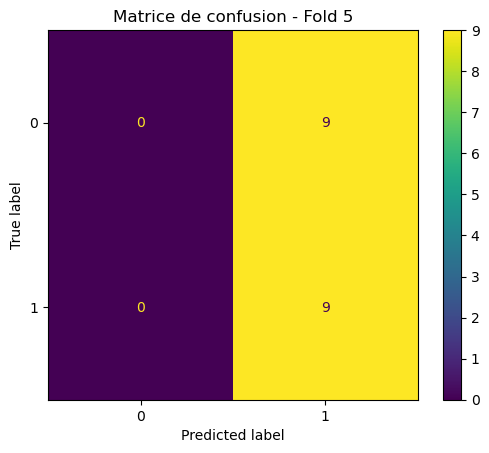


üîé Rapport de classification :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18

üì¶ Courbes sauvegard√©es dans eegnet_subject1_fold5_stats.npz


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

# Ajouter le dossier racine au path pour acc√©der √† src/
sys.path.append(os.path.abspath(".."))
from src.models.eegnet import EEGNetLight

def train_multirun():
    subject = 1
    runs = [6, 10, 14]
    data_dir = "../../data/processed"

    # Charger et concat√©ner les donn√©es de plusieurs runs
    datasets = []
    for run in runs:
        path = os.path.join(data_dir, f"subject_{subject}_run_{run}_epochs.npz")
        data = np.load(path)
        X = data["X"]
        y = data["y"]
        # üß† Fusion des classes 1 et 2
        y = np.where(y == 2, 1, y)  # 2 ‚Üí 1
        y = y - y.min()  # Correction pour que √ßa commence √† 0
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y, dtype=torch.long)
        datasets.append(TensorDataset(X_tensor, y_tensor))

    full_X = torch.cat([d.tensors[0] for d in datasets])
    full_y = torch.cat([d.tensors[1] for d in datasets])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    for train_idx, test_idx in skf.split(full_X, full_y):
        print(f"\n===== Fold {fold} =====")
        y_train, y_test = full_y[train_idx], full_y[test_idx]
        print(f"üî¢ R√©partition y_train : {torch.bincount(y_train)}")
        print(f"üî¢ R√©partition y_test  : {torch.bincount(y_test)}")

        train_loader = DataLoader(Subset(TensorDataset(full_X, full_y), train_idx), batch_size=8, shuffle=True)
        test_loader = DataLoader(Subset(TensorDataset(full_X, full_y), test_idx), batch_size=8)

        n_channels, n_timepoints = full_X.shape[2], full_X.shape[3]
        n_classes = len(torch.unique(full_y))
        model = EEGNetLight(n_channels=n_channels, n_timepoints=n_timepoints, n_classes=n_classes)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        losses, accuracies = [], []

        for epoch in range(10):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
            acc = 100 * correct / total
            losses.append(total_loss)
            accuracies.append(acc)
            print(f"üß† Fold {fold} ‚Äî Epoch {epoch+1:02d} ‚Äî Loss: {total_loss:.4f} ‚Äî Acc: {acc:.2f}%")

        # √âvaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                y_true.extend(yb.numpy())
                y_pred.extend(preds.argmax(1).numpy())

        # Matrice de confusion et rapport
        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Matrice de confusion - Fold {fold}")
        plt.grid(False)
        plt.show()

        print("\nüîé Rapport de classification :")
        print(classification_report(y_true, y_pred, zero_division=0))

        # Exporter stats
        np.savez(f"../../models/eegnet_subject{subject}_fold{fold}_stats.npz",
                 losses=np.array(losses), accuracies=np.array(accuracies))
        print(f"üì¶ Courbes sauvegard√©es dans eegnet_subject{subject}_fold{fold}_stats.npz")

        fold += 1

if __name__ == "__main__":
    train_multirun()


In [11]:
import mne
import os
from src.preprocessing.windowing import extract_epochs_from_annotations

subject = 1
runs = [6, 10, 14]
output_dir = "../../data/processed"
os.makedirs(output_dir, exist_ok=True)

for run in runs:
    files = mne.datasets.eegbci.load_data(subjects=[subject], runs=[run])
    raw = mne.io.read_raw_edf(files[0], preload=True)
    raw.rename_channels(lambda name: name.strip(".").upper())
    raw.set_montage("standard_1020", on_missing="ignore")

    X, y = extract_epochs_from_annotations(
        raw, tmin=0.0, tmax=4.0,
        output_path=os.path.join(output_dir, f"subject_{subject}_run_{run}_epochs.npz")
    )
    print(f"‚úÖ Run {run} export√© : {X.shape} √©chantillons")


Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
‚úÖ Extraction des √©v√©nements depuis les annotations...
‚úÖ 30 √©v√©nements d√©tect√©s : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
üìÄ Sauvegarde effectu√©e dans : ../../data/processed\subject_1_run_6_epochs.npz
üî¢ Extraction des donn√©es numpy : (30, 64, 641) ‚Äî Labels : [0 1 2]
‚úÖ Run 6 export√© : (30, 64, 641) √©chantillons
Extracting EDF parameters from C:\Users\Antoi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
‚úÖ Extraction des √©v√©nements depuis les annotations...
‚úÖ 30 √©v√©nements d√©tect√©s : {np.str_('T0'): 0, np.str_('T1'): 1, np.str_('T2'): 2}
üì